In [1]:
!pip install -q finance-datareader

In [28]:
import os
import time
from dateutil.parser import parse

import pandas as pd
import FinanceDataReader as fdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy 
from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [42]:
def get_data(sym):
    file_path = "/content/gdrive/MyDrive/stockData/"
    csv_path = os.path.join(file_path, f"{sym}.csv")
    df = pd.read_csv(csv_path, parse_dates=True, index_col = ['Date'])
    return df

In [54]:
def Min_Max_Scaler(dataframe):
    d_min = np.min(dataframe, 0)
    d_max = np.max(dataframe, 0)

    numerator = dataframe - d_min
    denominator = d_max - d_min

    df = numerator / (denominator + 1e-7)


    return df

In [55]:
def return_data(data, data_min, data_max):
    return data * (data_max - data_min) + data_min

In [87]:
class StockDataset(Dataset):
    
    def __init__(self, data, x_frames, y_frames, start, end):
        self.x_frames = x_frames
        self.y_frames = y_frames

        self.start = start
        self.end = end

        self.data = data.loc[self.start : self.end]


    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['Close','Open', 'High', 'Low', 'Volume', 'Change']]
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [66]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [67]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

In [68]:
class EarlyStopping:
    def __init__(self, args):
        self.patience = args.patience
        self.counter = 0
        self.best_score = None
        self.val_loss_min = np.Inf
        self.early_stop = False


        self.hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]

        if not os.path.isdir(args.path):
            os.mkdir(args.path)

    def __call__(self, val_loss, model):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            
            print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.val_loss_min, val_loss))

            torch.save(model.state_dict(), args.path+f'{args.exp_name}-{self.hash_key}-model.pt')
            self.val_loss_min = val_loss

        elif score > self.best_score:
            self.counter += 1
            print("EarlyStopping counter: {} out of {}".format(self.counter, self.patience))

            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.counter = 0

            print('Validation loss decreased --- Saving model ...')
            torch.save(model.state_dict(), args.path+f'{args.exp_name}-{self.hash_key}-model.pt')
            self.val_loss_min = val_loss

In [69]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True)

    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):

        X = X.to(args.device)
        y = y.to(args.device)

        X = X.transpose(0, 1).float()
        y_true = y[:, :, 0].float()
        
        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]


        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [70]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):
            X = X.to(args.device)
            y = y.to(args.device)

            X = X.transpose(0, 1).float()
            y_true = y[:, :, 0].float()

            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
    
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [101]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    prediction = []
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X = X.to(args.device)
            y = y.to(args.device)

            X = X.transpose(0, 1).float()
            y_true = y[:, :, 0].float()
            
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

            temp = []
            y = y_pred.cpu().detach().numpy()
            for i in range(len(y)):
                temp.append(y[i].item())

            prediction = prediction + temp


    test_acc = test_acc / len(testloader)
    return test_acc, prediction

In [72]:
def experiment(partition, args):
    hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)

    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice. Choose one of SGD, RMSprop, Adam')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
    
    early_stopping = EarlyStopping(args)

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        
        start = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        end = time.time()

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch+1, train_acc, val_acc, train_loss, val_loss, end-start))

        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early Stopping!!")
            end = time.time()
            break
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #


    model.load_state_dict(torch.load(args.path+f'{args.exp_name}-{hash_key}-model.pt'))

    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = [x for x in train_losses]
    result['val_losses'] = [x for x in val_losses]
    result['train_accs'] = [x for x in train_accs]
    result['val_accs'] = [x for x in val_accs]
    
    return model, vars(args), result

In [73]:
import hashlib
import json
from os import listdir
from os.path import isfile, join


def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    
    filepath = '/content/gdrive/MyDrive/results'
    if not os.path.isdir(filepath):
        os.mkdir(filepath)

    filename = '/content/gdrive/MyDrive/results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = '/content/gdrive/MyDrive/results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result)
    return df

In [74]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')

In [75]:
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)

In [76]:
def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc,'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')
    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

In [77]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

In [78]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(args.device)

cuda:0


In [79]:
# ====== Data Loading ====== #
args.symbol = 'AAPL'
args.batch_size = 32
args.x_frames = 5
args.y_frames = 1

In [80]:
df = get_data('AAPL')

d_min = np.min(df, 0)
d_max = np.max(df, 0)

df_scaled = Min_Max_Scaler(df)

In [149]:
trainset = StockDataset(df_scaled, args.x_frames, args.y_frames, '2000-01-01', '2018-01-01')
valset = StockDataset(df_scaled, args.x_frames, args.y_frames, '2018-01-01', '2019-01-01')

test_start = '2020-01-01'
test_end = '2020-12-24'

test = df_scaled.loc[test_start:test_end]
test_index = test.index
testset = StockDataset(df_scaled, args.x_frames, args.y_frames, test_start, test_end)

partition = {'train': trainset, 'val':valset, 'test':testset}

In [96]:
# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 1

In [97]:
# ====== Regularization ======= #
args.l2 = 0.0001
args.dropout = 0.5
args.use_bn = True

In [98]:
# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 5
args.patience = 5
args.path = '/content/gdrive/MyDrive/model_checkpoint/'

In [99]:
print(args)
model, setting, result = experiment(partition, deepcopy(args))

Namespace(batch_size=32, device='cuda:0', dropout=0.5, epoch=5, exp_name='exp1_lr', hid_dim=50, input_dim=6, l2=0.0001, lr=0.0001, n_layers=1, optim='Adam', path='/content/gdrive/MyDrive/model_checkpoint/', patience=5, symbol='AAPL', use_bn=True, x_frames=5, y_frames=1)
Epoch 1, Acc(train/val): 15.67/12.57, Loss(train/val) 0.03391/0.00798. Took 4.87 sec
Validation loss decreased (inf --> 0.0080).  Saving model ...
Epoch 2, Acc(train/val): 12.18/3.44, Loss(train/val) 0.01996/0.00086. Took 4.72 sec
Validation loss decreased --- Saving model ...
Epoch 3, Acc(train/val): 10.01/12.34, Loss(train/val) 0.01336/0.00851. Took 4.78 sec
EarlyStopping counter: 1 out of 5
Epoch 4, Acc(train/val): 8.40/19.89, Loss(train/val) 0.00938/0.02283. Took 4.70 sec
EarlyStopping counter: 2 out of 5
Epoch 5, Acc(train/val): 7.11/12.52, Loss(train/val) 0.00681/0.00882. Took 4.74 sec
EarlyStopping counter: 3 out of 5


In [102]:
test_acc, pred = test(model, partition, args)

In [103]:
test_acc

10.5271863256182

In [ ]:
def test_plot(prediction, t_start, t_end, t_index):
    len_pred = len(prediction)
    len_ind = len(t_index)

    temp = len_pred - len_ind
    ind = t_index[:-temp]

    test_df = pd.DataFrame({"Close": prediction}, index=ind)
    test_df = return_data(test_df, d_min[0], d_max[0])
    

In [104]:
len(pred)

224

In [158]:
a = len(test_index)-len(pred)
a

25

In [159]:
ind = test_index[:-a]

len(ind)

224

In [160]:
ind

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2020-11-05', '2020-11-06', '2020-11-09', '2020-11-10',
               '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-16',
               '2020-11-17', '2020-11-18'],
              dtype='datetime64[ns]', name='Date', length=224, freq=None)

In [154]:
ind[-1]

Timestamp('2020-11-18 00:00:00')

In [161]:
test_df = pd.DataFrame({"Close": pred}, index=ind)

In [162]:
test_df

,Close
Date,
2020-01-02,0.541785
2020-01-03,0.541487
2020-01-06,0.549108
2020-01-07,0.548571
2020-01-08,0.566374
...,...
2020-11-12,0.800500
2020-11-13,0.795810
2020-11-16,0.798083


In [136]:
test_df = return_data(test_df, d_min[0], d_max[0])

In [155]:
true_y = df.loc[ind[0]:ind[-1]]['Close']

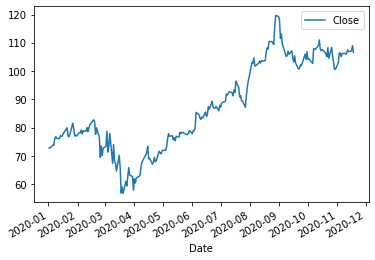

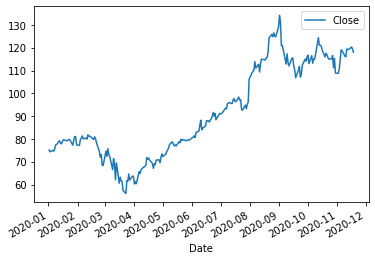

In [150]:
test_df.plot()
true_y.plot()

In [157]:
true_y = pd.DataFrame(true_y)
true_y

,Close
Date,
2020-01-02,75.09
2020-01-03,74.36
2020-01-06,74.95
2020-01-07,74.60
2020-01-08,75.80
...,...
2020-11-12,119.21
2020-11-13,119.26
2020-11-16,120.30


In [156]:
true_y

Date
2020-01-02     75.09
2020-01-03     74.36
2020-01-06     74.95
2020-01-07     74.60
2020-01-08     75.80
               ...  
2020-11-12    119.21
2020-11-13    119.26
2020-11-16    120.30
2020-11-17    119.39
2020-11-18    118.03
Name: Close, Length: 224, dtype: float64

In [153]:
test_df

,Close
Date,
2020-01-02,72.802053
2020-01-03,72.762229
2020-01-06,73.783020
2020-01-07,73.711068
2020-01-08,76.095774
...,...
2020-11-12,107.456964
2020-11-13,106.828691
2020-11-16,107.133219


In [ ]:
# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.001, 0.0001, 0.00001]
list_var2 = [1,2,3]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)